In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import cv2
from skimage.feature import hog
import pickle
from tqdm import tqdm
import hn_detect
from imp import reload
reload(hn_detect)
import hn_detect

In [2]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [3]:
dpi = matplotlib.rcParams['figure.dpi']

### Initialize classify model

In [5]:
svm = LinearSVC()

In [6]:
clf = CalibratedClassifierCV(svm)

### Load positive samples

In [394]:
file = open('./16x32/HOG_16x32', 'rb')
X_pos = pickle.load(file)
file.close()

In [395]:
X_pos.shape

(25954, 756)

### Load negative samples

In [396]:
file = open('./16x32/negative_set.p', 'rb')
X_neg = pickle.load(file)
file.close()

In [397]:
X_neg.shape

(68314, 756)

### Create label for each set

In [398]:
y_pos = np.ones(X_pos.shape[0])
y_neg = np.zeros(X_neg.shape[0])

In [399]:
X = np.vstack((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

### Split into training set and validation set

In [400]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

In [401]:
clf.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=LinearSVC())

In [82]:
print('Score trên tập train: ', clf.score(X_train,y_train))

Score trên tập train:  0.9819358358464546


In [83]:
print('Score trên tập validation: ', clf.score(X_val, y_val))

Score trên tập validation:  0.9792793748453025


In [84]:
y_train_pred = clf.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))

[[47426   385]
 [  807 17369]]


In [85]:
print('F1-score trên tập train: ', f1_score(y_train, y_train_pred))

F1-score trên tập train:  0.9668243807403284


In [86]:
y_val_pred = clf.predict(X_val)
print(confusion_matrix(y_val, y_val_pred))

[[20315   188]
 [  398  7380]]


In [87]:
print('F1-score trên tập test: ', f1_score(y_val, y_val_pred))

F1-score trên tập test:  0.9618141535253487


In [498]:
# Save model
file = open('./16x32/model_v1.0', 'wb')
pickle.dump(clf, file)
file.close()

## Test with some image in test set

In [4]:
train_path = '../data/train/'
test_path = '../data/test/'
extra_path = '../data/extra/'

In [5]:
names = os.listdir(test_path)

In [6]:
# load bounding box label
# df = pd.read_csv('./train_label.csv')
df = pd.read_csv('./test_label.csv')

In [7]:
# Load model
file = open('./16x32/model_v1.0', 'rb')
clf = pickle.load(file)
file.close()

In [8]:
# Parameters
scale = 2
winSize = (16,32)
step = 8
orientations = 9
pixels_per_cell = (4,4)
cells_per_block = (2,2)
threshold = 0.15

### Testing

1.png
10.png
100.png
1000.png
10000.png
10001.png
10002.png
10003.png
10004.png
10005.png


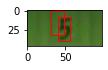

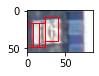

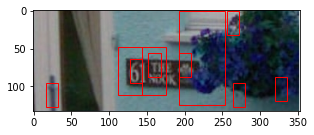

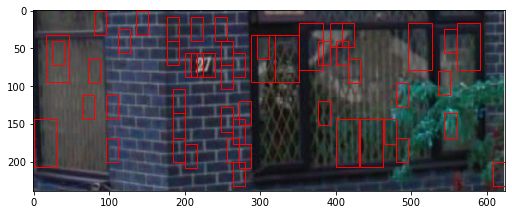

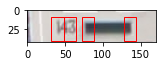

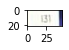

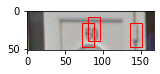

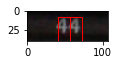

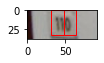

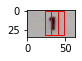

In [22]:
path = test_path
for name in names[:10]:
    digits = df[df.name == name]
    print(name)
    im = cv2.imread(os.path.join(path, name))
    figsize = im.shape[1]/dpi, im.shape[0]/dpi
    plt.figure(figsize=figsize)
    plt.imshow(im)
    ax = plt.gca()
    
    box, score = hn_detect.get_predicted_bbx(path, name, clf, threshold=0.55)
    for i in range(len(box)):
        left = box[i,0]
        top = box[i,2]
        width = box[i,1]-left+1
        height = box[i,3]-top+1
        rect = patches.Rectangle((left, top), width, height, edgecolor='r', facecolor='None')
        ax.add_patch(rect)

### Hard negative mining

In [9]:
df['right'] = df['left'] + df['width']-1
df['bottom'] = df['top'] + df['height'] - 1

In [10]:
df.head()

,name,height,left,top,width,label,right,bottom
0,1.png,30,43,7,19,5,61,36
1,2.png,23,99,5,14,2,112,27
2,2.png,23,114,8,8,1,121,30
3,2.png,23,121,6,12,10,132,28
4,3.png,16,61,6,11,6,71,21


In [ ]:
k = 1
names = os.listdir(train_path)
for name in tqdm(names):
    # Load image
    im = hn_detect.pre_process(train_path, name)
    
    # Get all bounding box for that image
    bbox = df[df.name == name]
    bbox = bbox[['left', 'right', 'top', 'bottom']].values
    
    # Find all false positive samples in image
    for (fd, proba, window) in hn_detect.get_fp(im, clf, bbox, scale=scale, winSize=winSize, step=step, orientations=orientations, 
                       pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, threshold=threshold):
        # Write false positve image to a folder
        cv2.imwrite('../data/fp/' + name + '_' + str(k) +'.png', window)
        k += 1

In [483]:
# List all image in false positive set
fp_path = '../data/fp/'
fp_names = os.listdir(fp_path)

In [486]:
fp = np.array([])
score = np.array([])
for name in tqdm(fp_names):
    # Load image
    im = cv2.imread(os.path.join(fp_path, name))
    fd = hog(im, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    fd = fd.reshape(1,-1)
    prob = clf.predict_proba(fd)
    
     # Append feature and score of false positive image to an array
    fp = np.append(fp, fd)
    score = np.append(score, proba)
    

100%|████████████████████████████████████████████████████████████████████████████| 15193/15193 [04:39<00:00, 54.31it/s]


In [493]:
# Reshape false positive feature to size nsamples x nfeature
fp = fp.reshape(score.size,-1)
fp.shape

(15193, 756)

In [494]:
# Save false positive feature
file = open('./16x32/false_positive', 'wb')
pickle.dump(fp, file)
file.close()

In [495]:
# Save false positive score
file = open('./16x32/probability', 'wb')
pickle.dump(score, file)
file.close()

### Retrain model on false positive data

In [499]:
# Load false positive data and its score
file = open('./16x32/false_positive', 'rb')
fp = pickle.load(file)
file.close()

file = open('./16x32/probability', 'rb')
fp_score = pickle.load(file)
file.close()


In [501]:
# Create label for false positive set
y_neg_new = np.zeros(fp.shape[0])

In [502]:
# Create training set
X_new = np.vstack((X_pos, fp))
y_new = np.concatenate((y_pos, y_neg_new))

In [505]:
# Split into training and validation set
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(X_new, y_new, test_size=0.3, random_state=25)

In [506]:
# Fit model
clf.fit(X_new_train, y_new_train)

CalibratedClassifierCV(base_estimator=LinearSVC())

In [507]:
# Predict and scorre on train set
y_new_train_pred = clf.predict(X_new_train)
print('F1-score trên tập train mới: ', f1_score(y_new_train, y_new_train_pred))

F1-score trên tập train mới:  0.8976592724540065


In [508]:
# Predict and score on validation set
y_new_val_pred = clf.predict(X_new_val)
print('F1-score trên tập train mới: ', f1_score(y_new_val, y_new_val_pred))

F1-score trên tập train mới:  0.8862019914651493


In [733]:
# Save model
file = open('./16x32/model_v2.0', 'wb')
pickle.dump(clf, file)
file.close()

### Testing re-trained model

In [11]:
# Load model
file = open('./16x32/model_v2.0', 'rb')
clf1 = pickle.load(file)
file.close()

1.png
10.png
100.png
1000.png
10000.png
10001.png
10002.png
10003.png
10004.png
10005.png


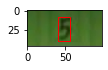

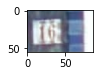

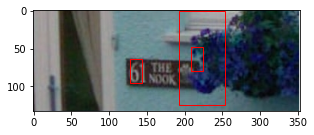

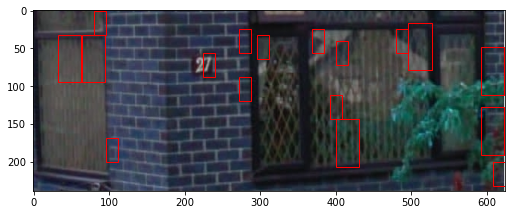

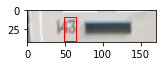

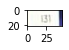

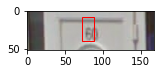

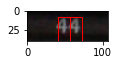

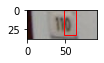

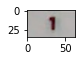

In [24]:
path = test_path
names = os.listdir(path)
for name in names[:10]:
    digits = df[df.name == name]
    print(name)
    im = cv2.imread(os.path.join(path, name))
    figsize = im.shape[1]/dpi, im.shape[0]/dpi
    plt.figure(figsize=figsize)
    plt.imshow(im)
    ax = plt.gca()
    
    box, score = hn_detect.get_predicted_bbx(path, name, clf1, threshold=0.55)
    for i in range(len(box)):
        left = box[i,0]
        top = box[i,2]
        width = box[i,1]-left+1
        height = box[i,3]-top+1
        rect = patches.Rectangle((left, top), width, height, edgecolor='r', facecolor='None')
        ax.add_patch(rect)

### Calculate score on test set

In [161]:
reload(hn_detect)
import hn_detect

In [162]:
# Calculate score on 2000 test images
res, score, fn = hn_detect.scoring(clf1, test_path, df, nsamples=2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [23:07<00:00,  1.44it/s]


In [165]:
# Sorting score descending
index = np.argsort(score)
index = index[::-1]
res = res[index]

In [166]:
P = np.zeros(len(score))
R = np.zeros(len(score))

for i in range(len(score)):
    P[i] = np.sum(res[:i+1])/(i+1)
    R[i] = np.sum(res[:i+1])/fn

In [12]:
# Calculate score on 2000 test images
res1, score1, fn1 = hn_detect.scoring(clf, test_path, df, nsamples=2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [17:19<00:00,  1.92it/s]


In [178]:
file = open('./result1', 'wb')
pickle.dump(res1, file)
file.close()

In [179]:
file = open('./score1', 'wb')
pickle.dump(score1, file)
file.close()

In [13]:
file = open('./fn', 'wb')
pickle.dump(fn1, file)
file.close()

In [10]:
file = open('./result1', 'rb')
res1 = pickle.load(file)
file.close()

In [11]:
file = open('./score1', 'rb')
score1 = pickle.load(file)
file.close()

In [14]:
index = np.argsort(score1)
index = index[::-1]
res1 = res1[index]

In [15]:
P1 = np.zeros(score1.size)
R1 = P1.copy()
for i in range(score1.size):
    P1[i] = np.sum(res1[:i+1])/(i+1)
    R1[i] = np.sum(res1[:i+1])/fn1

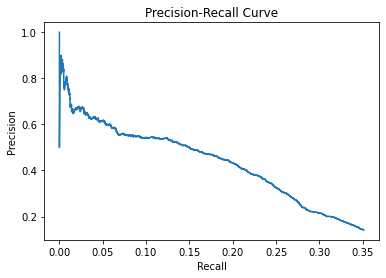

In [17]:
plt.plot(R1, P1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

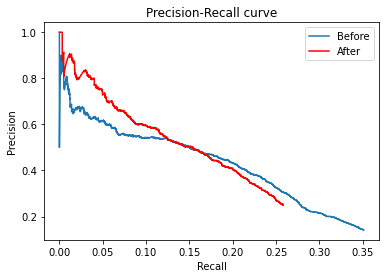

In [186]:
plt.plot(R1, P1, label='Before')
plt.plot(R, P, 'r', label='After')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve')
plt.show()